Section 1 needs to be run to get the data.

Section 2 must be run to load the saved model and get sigma.

Section 3 is an example of how we can use likelihood to diagnose where the issues in our model are. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from pickle import load
import tensorflow as tf
from tensorflow import keras
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

tf.random.set_seed(42)
K = keras.backend

from sklearn.preprocessing import StandardScaler,PowerTransformer
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import os
from helper import *


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


Run the below cell if using a GPU.

In [2]:
#using laptop gpu
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
k = 8
J = 32
save_time_step = 0.005
h=1 
c=10
b=10

# 1: Prepare data #

In [3]:
#load train, validation and test datasets 
valid_dataset = np.load("../../../data/truth_run/climate_change_exp/val.npy")
train1 = np.load("../../../data/truth_run/climate_change_exp/train_set_1.npy")
train2 = np.load("../../../data/truth_run/climate_change_exp/train_set_2.npy")
train3 = np.load("../../../data/truth_run/climate_change_exp/train_set_3.npy")
f20 = np.load("../../../data/truth_run/training_dataset.npy")
train4 = np.concatenate([f20, 20*np.ones(shape=(f20.shape[0],k,1))],axis=2)[:200000]

test_dataset = np.load("../../../data/truth_run/climate_change_exp/full_28_set.npy")[:int(10000/0.005)]
f_array = 28*np.ones((test_dataset.shape[0],k,1))
test_dataset = np.concatenate([test_dataset,f_array],axis=2)

In [4]:
def _rhs_X_dt(X, F,U,dt=0.005):
    """Compute the right hand side of the X-ODE."""

    dXdt = (-np.roll(X, 1,axis=1) * (np.roll(X, 2,axis=1) - np.roll(X, -1,axis=1)) -
                X + F - U)

    return dt * dXdt 


def U(Xt,Xt_1,F,dt=0.005):
    k1_X = _rhs_X_dt(Xt,F,U=0)
    k2_X = _rhs_X_dt(Xt + k1_X / 2,F, U=0)
    Xt_1_pred = k2_X + Xt 
    #print(Xt_1_pred)
    Ut = (Xt_1_pred - Xt_1 )/dt

    return Ut


def create_dataset_with_u(climate_eval_dataset,dt=0.005):
    """Shape of climate_eval_dataset is num_steps x k x 2"""
    
    data = climate_eval_dataset[:,:,0] #so we get num_steps x k shape    
    u_data =  U(data[:-1,:],data[1:,:],climate_eval_dataset[0,0,-1])    
    x_prev = data[:-1,:]
    
    return np.stack([u_data,x_prev],axis=2)
    
    

In [6]:
valid_dataset_new = create_dataset_with_u(valid_dataset)
test_dataset_new = create_dataset_with_u(test_dataset)
train1_new = create_dataset_with_u(train1)
train2_new = create_dataset_with_u(train2)
train3_new = create_dataset_with_u(train3)
train4_new = create_dataset_with_u(train4)


In [7]:
history_length = 700

val_seq_length = 5000

In [8]:
def prepare_datasets_for_RNN(dataset,history_length):
    dataset = dataset[:(dataset.shape[0]//history_length)*history_length,:] # to make it multiple of history
    dataset_shape = dataset.shape[0]
    reshaped = dataset.reshape(int(dataset_shape/history_length),history_length,k,2)
    add_on = reshaped[1:,0,:,:]
    add_on = add_on.reshape(int(dataset_shape/history_length)-1,1,k,2)
    reshaped = reshaped[:-1,:,:,:]
    concat = np.concatenate((reshaped,add_on),axis=1)
    concat = concat.reshape(((int(dataset_shape/history_length)-1)*(history_length+1),k,2))
    concat = concat.reshape((k*(int(dataset_shape/history_length)-1)*(history_length+1),2),order="F")
    features = concat.reshape(k*(int(dataset_shape/history_length)-1),(history_length+1),2)
    
    return features

def prepare_train_dataset(train1,train2,train3,train4,history_length):
    """each of these train sets has a different F value """
    train_1_features = prepare_datasets_for_RNN(train1,history_length)
    train_2_features = prepare_datasets_for_RNN(train2,history_length)
    train_3_features = prepare_datasets_for_RNN(train3,history_length)
    train_4_features = prepare_datasets_for_RNN(train4,history_length)
    return np.concatenate([train_1_features,train_2_features,train_3_features,train_4_features],axis=0)

def prep_holdout(test_dataset):
    return np.transpose(test_dataset,[1,0,2])
    

In [9]:
train_nn_features = prepare_train_dataset(train1_new,train2_new,train3_new,train4_new,history_length)

valid_dataset_for_loglik = prepare_datasets_for_RNN(valid_dataset_new,val_seq_length)

test_nn_features = prep_holdout(test_dataset_new)



In [10]:
test_nn_features.shape

(8, 1999999, 2)

In [11]:
u_mean = train_nn_features[:,:,0].mean()
u_std = train_nn_features[:,:,0].std()

x_mean = train_nn_features[:,:,1].mean()
x_std = train_nn_features[:,:,1].std()

def scaled_data(input_dataset):
    data = input_dataset.copy()
    data[:,:,0] = (data[:,:,0] - u_mean)/u_std 
    data[:,:,1] = (data[:,:,1] - x_mean)/x_std 
    return data

train_nn_features = scaled_data(train_nn_features)
test_nn_features = scaled_data(test_nn_features)
valid_dataset_for_loglik = scaled_data(valid_dataset_for_loglik)


train_nn_input = train_nn_features[:,:-1,:]
train_nn_output = train_nn_features[:,1:,:]

test_nn_input = test_nn_features[:,:-1,:]
test_nn_output = test_nn_features[:,1:,:]


valid_loglik_input = valid_dataset_for_loglik[:,:-1,:]
valid_loglik_output = valid_dataset_for_loglik[:,1:,:]


In [16]:
################################################################################################################

#Note that for loglik we multiply dt (0.005) by u_std as we are training a model in a scaled space. This factor 
#can be shown to arise if one considers a change of variables for likelihood as in the Appendix of our paper.

################################################################################################################


def loglik_gaussian_x(array,mean,sigma):
    sigma = sigma* tf.ones((mean.shape[0],mean.shape[1],1))
    term = -K.log((sigma**2) *2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5 * term 
    return loglik - np.log(u_std*0.005)

def calculate_sigma_mle(input_list,simulator):
    
    u_det = u_det_model.predict(input_list[0][:,:,-1:])
    u_true = input_list[0][:,:,:1]
    r = u_true - (u_det-u_mean)/u_std

    x_mean_out = simulator.predict([r,input_list[2],input_list[3]])[0]

    u_det_target = u_det_model.predict(input_list[1][:,:,-1:])
    u_true_target = input_list[1][:,:,:1]
    r_target = u_true_target - (u_det_target-u_mean)/u_std

    sigma_mle_x = (np.mean((x_mean_out- r_target)**2))**0.5

    return sigma_mle_x
    

def valid_loss(valid_list,simulator,sigma_x):
    """negative loglik for full generative model on validation set"""
    
    u_det = u_det_model.predict(valid_list[0][:,:,-1:])
    u_true = valid_list[0][:,:,:1]
    r = u_true - (u_det-u_mean)/u_std

    x_mean_out = simulator.predict([r,valid_list[2],valid_list[3]])[0]

    u_det_target = u_det_model.predict(valid_list[1][:,:,-1:])
    u_true_target = valid_list[1][:,:,:1]
    r_target = u_true_target - (u_det_target-u_mean)/u_std    
    
    loglik_x = loglik_gaussian_x(array=r_target,mean=x_mean_out,sigma=sigma_x)
    loss = -loglik_x
    return tf.reduce_mean(loss)
    
    
def point_info(valid_list,simulator,sigma_x):
    """returns loglik per point, the mean and the target"""
    
    u_det = u_det_model.predict(valid_list[0][:,:,-1:])
    u_true = valid_list[0][:,:,:1]
    r = u_true - (u_det-u_mean)/u_std

    x_mean_out = simulator.predict([r,valid_list[2],valid_list[3]])[0]

    u_det_target = u_det_model.predict(valid_list[1][:,:,-1:])
    u_true_target = valid_list[1][:,:,:1]
    r_target = u_true_target - (u_det_target-u_mean)/u_std    
    
    loglik_x = loglik_gaussian_x(array=r_target,mean=x_mean_out,sigma=sigma_x)
    loss = -loglik_x
    return -loss,x_mean_out,r_target

def loglik_gaussian(array,mean,sigma):
    sigma = sigma* tf.ones((mean.shape[0],mean.shape[1],1))
    term = -K.log((sigma**2) *2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5 * term 
    loglik = tf.reduce_mean(loglik)
    return loglik - np.log(u_std*0.005)

In [17]:
####### The below hidden states are the l part of the full (r,l) hidden state ###############

hidden_state_size = 4


hidden_in_train = np.zeros(shape=(train_nn_features.shape[0],hidden_state_size))
hidden_in_test = np.zeros(shape=(test_nn_features.shape[0],hidden_state_size))


hidden_in_valid_loglik = np.zeros(shape=(valid_dataset_for_loglik.shape[0],hidden_state_size))


input_list = [train_nn_input,train_nn_output,hidden_in_train,hidden_in_train]


# 2 : Load saved model #

In [15]:
rnn = keras.models.load_model("rnn_update.h5")
u_det_model = keras.models.load_model("u_nn.h5")

In [ ]:
sigma_mle_x = calculate_sigma_mle(input_list,simulator=rnn)
sigma_mle_x

# 3: F = 28 hold-out log-likelihood #

The loss is the negative log-lik so we just take the negative loss.

## F = 28 ##

In [18]:
test_list = [test_nn_input[:,:],test_nn_output[:,:],hidden_in_test,hidden_in_test]

In [19]:
test_nn_input.shape

(8, 1999998, 2)

In [117]:
#10000 MTU
-valid_loss(test_list,rnn,0.015752254)

<tf.Tensor: shape=(), dtype=float32, numpy=2.6867075>

In the first 300 steps of the sequence, there are some points with very low log-likelihoods. 

In [20]:
test_list = [test_nn_input[:,:300],test_nn_output[:,:300],hidden_in_test,hidden_in_test]

In [21]:
loglik,output,target = point_info(test_list,rnn,0.015752254)

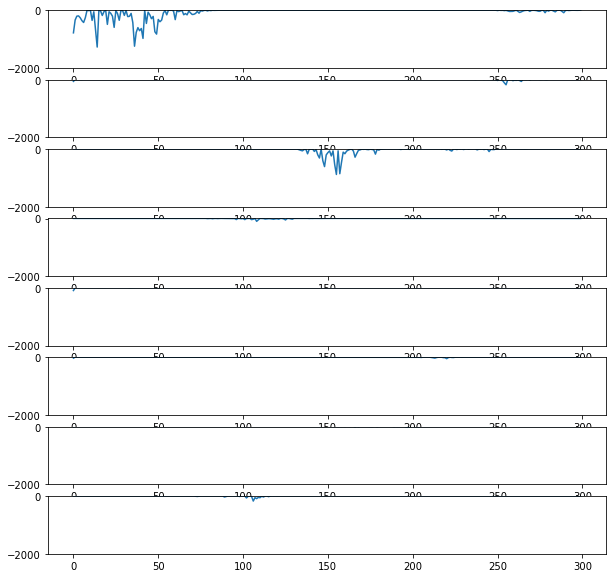

In [22]:
fig,ax = plt.subplots(ncols=1,nrows=8,figsize=(10,10))
for i in range(8):
    
    ax[i].plot(loglik[i,:])
    ax[i].set_ylim([-2000,7])

#x axis is time step
#y axis is log-likelihood per step
#each panel is each of the k X_{k,t} components

For k=1, the start of the seq is poorly modelled. Let's examine this further below (the first 100 time steps).

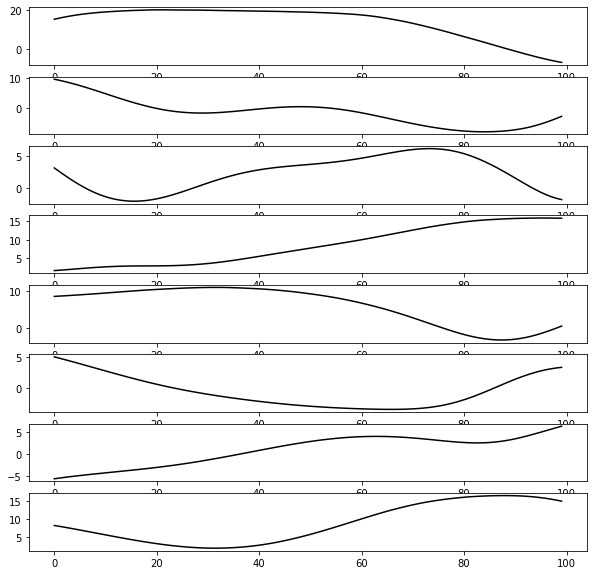

In [23]:
fig,ax = plt.subplots(ncols=1,nrows=8,figsize=(10,10))
for i in range(8):
    ax[i].plot(test_dataset[:100,i,0],"k")
    
#x axis is time step
#y axis is value of X_{k,t}
#each panel is each of the k X_{k,t} components

Our RNN is modelling U, so let's look at the timeseries of this.

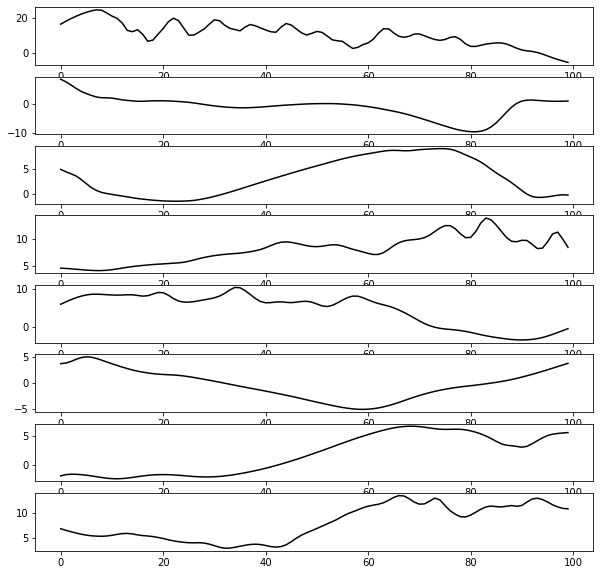

In [25]:
fig,ax = plt.subplots(ncols=1,nrows=8,figsize=(10,10))
for i in range(8):
    ax[i].plot(test_dataset_new[:100,i,0],"k")
    
#x axis is time step
#y axis is value of U_{k,t}
#each panel is each of the k U_{k,t} components

Below, we see plots of the teacher-forced prediction of U at each point, in blue, with +/- 2 sigma shown in dotted red. The truth is in black. For k = 1, the truth does not lie in the +/- 2 sigma interval. For trajectories like this, we would want to have a larger sigma to reflect the uncertainty in what the true value is. 

Note that elsewhere the small value of sigma is suitable, as the truth lies within the +/- 2 sigma band.

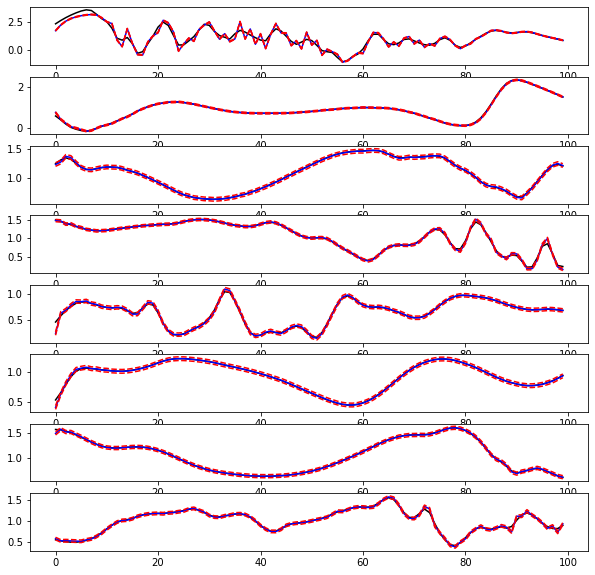

In [26]:
fig,ax = plt.subplots(ncols=1,nrows=8,figsize=(10,10))
for i in range(8):
    ax[i].plot(target[i,:100],color="k")
    ax[i].plot(output[i,:100],color="blue")
    ax[i].plot(output[i,:100]+2*0.0157,color="red",linestyle="--")
    ax[i].plot(output[i,:100]-2*0.0157,color="red",linestyle="--")
